Расчет степени ионизации:
Изменение степени ионизации $x$ описывается формулой:
$\frac{dx}{dt} = \frac{V_{ion} - V_{recomb}}{n_H}$
,где $V_{ion} = \xi_H n_H (1-x)$, $V_{recomb} = \alpha n_H^2 x$.

$\xi_H = \int_E_0^\infty \sigma_{ion} (\frac{E_0}{E})^3 F(E)dE$, где F(E) дифференциальный поток
$\alpha_H = 2.6 * 10^{-13} (\frac{T}{10^4 K})^{-0.85}$ см$^3$с$^{-1}$ - значение из статьи кара

Это уравнение будем решать численно явной схемой. Проход по узлам будет из центра наружу. В каждом узле будем искать равновесное значение x (то есть когда оно будет слабо меняться со временем). Шаг по времени данной схемы нужно брать отличный от шага по времени в решении уравнений Эйлера (например можно взять время прохождения светом текущей пространственной ячейки). После нахождения равновесного значения в очередном узле, необходимо сделать пересчет потока излучения, так как он будет зависеть от степени ионизации.

Этот расчет организован в функции ioniz_frac, которая задается в файле light_func.py

Оценка степени ионизации их температуры
$X_p + X_p^2 n_B (\frac{2\pi}{m_e T})^{3/2}e^{\frac{\delta H}{T}} = 1$

$X_p = \frac{-1 \pm \sqrt{ 1 + 4(n_B (\frac{2\pi}{m_e T})^{3/2}e^{\frac{\delta H}{T}})}}{2 n_B (\frac{2\pi}{m_e T})^{3/2}e^{\frac{\delta H}{T}}}$

,где $\delta H = 13.6 эВ$, а $X_p = \frac{n_p}{n_B}$. Берем корень только с +, так как с - нефизичный.


In [1]:
def ioniz_estim(n_H, T):
    m_e = 0.5e6
    delta_H = 13.6
    T_new = T/11604 # температура в эВ
    if np.any((T_new<=0.02)):
        for i in range(T_new.shape[0]):
            if T_new[i]<=0.02:
                T_new[i]=0.02
    n_H_new = n_H*(1.2e-6)**3 # концентрация водорода в эВ^-3
    a = n_H_new*np.exp(delta_H/T_new)*(2*np.pi/(m_e*T_new))**(3/2)
    x = (-1 + np.sqrt(1+4*a))/(2*a)
    return x

In [2]:
# Параметры задачи
z = 1500  # Красное смещение
M_pbh = 1e9 # масса черной дыры в солнечных массах
t_end_years = 1e9 # Конечное время симуляции в годах
draw_step = 10000 # Шаг для отрисовки

In [3]:
kkk = 1.247e-7
a_0 = 1/(z+1)

In [4]:
# Множители для отладки
PP = 1  #множитель перед членом с давлением
GG = 1    #гравитационная постоянная (приравнять нулю, чтобы посмотреть только с давлением)
RRRho = 1  #множитель увеличивающий начальную плотность в центральной граничной точке
TT = 1  # Множитель перед температурой в центре

In [5]:
# Различные физические константы
k = 1.38e-23 # Постоянная Больцмана Дж/К
m_p = 1.67e-27 # Масса протона кг
c = 3e8 # Скорость света
pk_to_meter = 3e16 # Переводной коэффициент пк->м
G = GG * 6.67e-11 # гравитационная постоянная Н*м^2/кг^2
M_sun = 2e30 # масса солнца в кг
gamma = 5/3 # коэффициент адиабаты
t_end_seconds = 3.154e7 * t_end_years


Rho_mean = 8.5e-27 * 0.04 * (1+z)**3 # Средняя плотность Вселенной

In [6]:
import matplotlib.pyplot as plt
# Импорт функций для расчетов темной материи
from md import *
# Импорт функций для расчетов излучения
from light_func import *
%matplotlib inline
import numpy as np
plt.style.use(['seaborn-v0_8-notebook'])
plt.rcParams.update({"figure.facecolor": (0,0,0,0),
                     "figure.dpi": 90,
                     "animation.html": "jshtml",
                     "animation.embed_limit": 100})
plt.rcParams['font.size'] = 20

In [7]:
# Блок констант далее требуется для условия Куранта-Фридрихсона-Леви (КФЛ)
mu = 1 # Средний молекулярный вес, это значение для водорода, если будем что-то добавлять то будет что-то другое
a1 = 1/119  # первый коэффициент в формуле для температуры
a2 = 1/115  # второй коэффициент в формуле для температуры
T = 2.7 * (1+z) * (1 + a1**(-1)*(1+z)**(-1)/(1+a2**(3/2)*(1+z)**(3/2))) ** (-1)
a = np.sqrt(k*T / (mu*m_p))   #скорость звука в м/c

# Радиус остановки DM
r_s = 6.7 * 10**22 * (M_pbh/10**9)**(1/3) * ((1+z)/18)**(-4/3) * 3.24 * 10**(-19)
r_virial = r_s/4

In [8]:
# Диапазон сетки
r_min = r_virial#1 # внутренняя граница сетки в парсеках
r_max = 10*r_s#100 # внешняя граница сетки в парсеках

# Логарифмическая сетка
r_log_min = np.log(r_min)
r_log_max = np.log(r_max)
length_r = 30
r_log = np.linspace(r_log_min, r_log_max, length_r)
r_phys = np.exp(1) ** r_log
log_step = r_log[1]-r_log[0]

In [9]:

# Задание первичного (пробного) условия КФЛ
# Далее условие будет пересчитываться
# Вид условия: С = ((a + |u_x|) * dt)/dx < 0.5
# Здесь a-эффективная скорость звука, u_x-скорость газа, dt и dx шаги по времени и пространству
# Константа в условии КФЛ
C = 0.1

# Для логарифмической сетки
dt = C * (r_phys[1]-r_phys[0]) * pk_to_meter / a

In [10]:
# Инициализация массивов для хранения различных переменных
U = np.zeros((2, length_r)) # скорость газа U_0 = 0
Rho = np.zeros((2, length_r)) # плотность газа Rho
P = np.zeros((2, length_r)) # давление газа P
T = np.zeros(length_r) # температура газа T
Eps = np.zeros(length_r) # внутренняя энергия газа U
E = np.zeros((2, length_r)) # Полная энергия
n_H = np.zeros(length_r) # количественная плотность водорода
Phi = np.zeros(length_r)  # гравитационный потенциал
S_dual = np.zeros(length_r)
V_dual = np.zeros(length_r)
S = np.zeros(length_r)
V_dual = np.zeros(length_r + 1)
V = np.zeros(length_r + 1)
S_dual = np.zeros(length_r)
du_dr = np.zeros(length_r)
U_half = np.zeros(length_r)

In [11]:
# Блок далее нужен для синхронизации размеров векторов, чтобы далее не возникало ошибок связанных с их несовпадением
r_log_temp_2 = np.append(r_log[0] - log_step, r_log)
r_log_temp_2 = np.append(r_log_temp_2, r_log[-1] + log_step)
r_temp_2 = np.exp(1) ** r_log_temp_2
Phi_temp = (-G*mdmt(r_temp_2[0]/r_s)/(r_temp_2[0] * pk_to_meter) * (Rho_mean * 4*np.pi/3 * (r_s*pk_to_meter)**3)
              -G*M_pbh*M_sun/(r_temp_2[0] * pk_to_meter))
Phi_temp_2 = (-G*mdmt(r_temp_2[-1]/r_s)/(r_temp_2[-1] * pk_to_meter) * (Rho_mean * 4*np.pi/3 * (r_s*pk_to_meter)**3)
              -G*M_pbh*M_sun/(r_temp_2[-1] * pk_to_meter))
r_log_temp = np.append(r_log, r_log[-1] + log_step)
r_temp = np.exp(1) ** r_log_temp
r_log_temp_2 = r_log_temp - 0.5*log_step
r_temp_3 = np.exp(1) ** r_log_temp_2

In [12]:
# Задание обьемов и площадей
S = 4 * np.pi * (r_temp_3[1:]+r_temp_3[:-1])**2 / 4 * pk_to_meter**2
V = 4/3 * np.pi * (r_temp_3[1:]**3 - r_temp_3[:-1]**3) * pk_to_meter**3
S_dual = 4 * np.pi * (r_temp[1:] + r_temp[:-1])**2 / 4 * pk_to_meter**2
V_dual = 4/3 * np.pi * (r_temp_3[1:]**3 - r_temp_3[:-1]**3) * pk_to_meter**3

In [13]:
# Начальные условия
for j in range(length_r):
    # Гравитационный потенциал
    Phi[j] = (-G*mdmt(r_phys[j]/r_s)/(r_phys[j] * pk_to_meter) * (Rho_mean * 4*np.pi/3 * (r_s*pk_to_meter)**3)
              -G*M_pbh*M_sun/(r_phys[j] * pk_to_meter)) # в м**2/с**2

    # Температура
    T[j] = 2.7 * (1+z) * (1 + a1**(-1)*(1+z)**(-1)/(1+a2**(3/2)*(1+z)**(3/2)))**(-1)  # в кельвинах

    # Плотность барионов
    # omega_b = 0.049
    # omega_m = 0.308
    # Rho[0, j] = omega_b * rrb(r_phys[j]/r_s)/omega_m    #пробная плотность в Rho_mean
    Rho[0, j] = rrb(r_phys[j]/r_s)
    # Так как переопределили Rho и оставили метры то нужно переопределить единицы массы
    M_unit = Rho_mean   # Коэффициент перевода единиц массы в кг

    # Концентрация водорода
    n_H[j] = (Rho[0, j])/(m_p/M_unit)

    # массовая плотность внутренней энергия
    Eps[j] = (n_H[j] * 3/2 * k/M_unit * T[j])/(Rho[0, j])  # В Дж/M_unit

    # Скорости
    U[0, j] = 0   # В м/c

    # Плотность полной энергии
    E[0, j] = (Rho[0, j]) * (U[0, j]**2/2 + Eps[j]) # В M_unit/м*с**2

    # Уравнение состояния
    P[0, j] = (gamma - 1) * (Rho[0, j]) * Eps[j]   # Давление в M_unit/м*с**2

In [14]:
# Изменение размеров векторов и применение граничного условия к потенциалам
Phi = np.append(Phi_temp, Phi)
Phi = np.append(Phi, Phi_temp_2)
P[0, -1] = P[0, -2]
U[0, -1] = U[0, -2]

# Искуственное увеличение плотности и температуры в центре (работает если был изменен соответствующий отладочный параметр)
Rho[0,0] = Rho[0,0]*RRRho
T[0] = T[0]*TT

In [15]:
# Инициализация различных переменных для расчета
i = 0 # Счетчик шагов по времени
sim_time = 0 # Общее время симуляции
dt_minimizer = 0.0009 # Множитель который будет использован при пересчете шагов по времени
indicator_2 = False # Индикатор нужный для пересчета шага по времени
Rho_dump_left = np.zeros(2) # Переменная для хранения плотности которая уходит к ЧД за пределы сетки
LL = np.zeros(length_r)  # Переменная для хранения разницы членов гравитации и давления

# Массивы для отрисовки
U_draw = np.zeros((2,Rho.shape[1]))
Rho_draw = np.zeros((2,Rho.shape[1]))
E_draw = np.zeros((2,Rho.shape[1]))
U_draw[1,:] = U[0, :]
Rho_draw[1,:] = Rho[0, :]
E_draw[1,:] = E[0, :]
draw_time = 0

In [16]:
# Выбор начального распределения степени ионизации и процедуры расчета излучения
x = np.exp(-5*r_phys/r_s) # Начальное распределение степени ионизации
x_draw = x  # Массив для отрисовки степени ионизации
E_photon = 5000 # Энергия фотонов в эВ
light_procedure_selector = 1   # 0 - для простой оценки, 1 - для минимального расчета потерь излучения из уравнения переноса

In [20]:
# Расчет решения уравнений Эйлера с излучением
while (sim_time < t_end_seconds):
    if (i == 0):
        i = 1

    # Лагранжев шаг

    # Вычисление скорости на полшага вперед по времени
    dP_dx = (P[0,1:] - P[0,:-1]) / log_step
    dPhi_dx = (Phi[1:] - Phi[:-1]) / log_step

    if light_procedure_selector == 1:
        H, Pressure_euler_coupling, Energy_euler_coupling = eddington_light(n_H, x, E_photon, M_pbh, r_phys, M_unit)
        LL[:-1] = (- PP * (0.5*dt * dP_dx/(r_phys[:-1] * pk_to_meter)) / (Rho[0,:-1])
                                - (0.5*dt * dPhi_dx[1:-1]/(r_phys[:-1] * pk_to_meter))
                                - 0.5*dt*Pressure_euler_coupling/(Rho[0,:-1]))
    elif light_procedure_selector == 0:
        H, Pressure_euler_coupling, Energy_euler_coupling = easy_eddington_light(x, r_phys, M_pbh)
        LL[:-1] = (- PP * (0.5*dt * dP_dx/(r_phys[:-1] * pk_to_meter)) / (Rho[0,:-1])
                                - (0.5*dt * dPhi_dx[1:-1]/(r_phys[:-1] * pk_to_meter))
                                - 0.5*dt*Pressure_euler_coupling/Rho[0,:-1])

    U_half[:-1] = U[0,:-1] + LL[:-1]
    U_half[-1] = U_half[-2]

    # Вычисление производной скорости по времени
    du_dx = (U_half[1:] - U_half[:-1]) / log_step
    du_dr[:-1] = du_dx / (r_phys[:-1] * pk_to_meter)
    du_dr[-1] = du_dr[-2]

    # Промежуточная полная энергия
    if light_procedure_selector == 1:
        Energy_euler_coupling = np.append(Energy_euler_coupling, 0)

    E_inter = (E[0,:] - PP * P[0,:]*du_dr*0.5*dt - Rho[0,:] * U_half[:] * dPhi_dx[:-1]/(r_phys * pk_to_meter) * 0.5*dt
                        -0.5*dt*Energy_euler_coupling/(log_step*r_phys*pk_to_meter))

    # Шаг адвекции
    # В зависимости от направления скорости переносим параметры (плотность, энергию) из одной ячейки в другую

    # Вычисление скорости
    U[1,:] = U[0,:] - np.sign(U_half) * (dt * U_half ** 2 * S_dual) / V_dual
    # U[1,:] = np.sign(U_half) * np.abs(np.abs(U[0,:]) - dt * U_half ** 2 * S_dual) / (V_dual)
    U[1,:-1] =  U[1,:-1] + np.sign(U_half[1:])*( dt * U_half[1:]**2 * S_dual[1:]) / (V_dual[1:]) * np.where(U_half[1:]<0, 1, 0)
    U[1,1:] = U[1,1:] + np.sign(U_half[:-1])*( dt * U_half[:-1]**2 * S_dual[:-1]) / (V_dual[:-1]) * np.where(U_half[:-1]>0, 1, 0)
    U[1,-1] = U[1,-2]

    # Вычисление плотности
    Rho[1,1:] = Rho[0,1:] - np.abs((dt * Rho[0,1:] * U_half[1:] * S[1:]) / V[1:])
    # Следующую строчку нужно использовать чтобы вещество вылетало к центру. Ту что далее тогда нужно закомментировать
    Rho[1,0] = Rho[0,0] - np.abs((dt * Rho[0,0] * U_half[0] * S[0]) / V[0])
    # Следующую строчку нужно использовать если нужно накапливать плотность крайней точке. Ту что до этого тогда нужно закомментировать
    # Rho[1,0] = Rho[0,0] - np.abs((dt * Rho[0,0] * U_half[0] * S[0]) / V[0])*(U_half[0]>0)
    Rho_dump_left[1] = Rho_dump_left[0] + np.abs((dt * Rho[0,0] * U_half[0] * S[0]) / V[0]) * (U_half[0]<0)
    Rho[1,:-1] = Rho[1,:-1] + np.abs((dt * Rho[0,1:] * U_half[1:] * S[1:]) / V[1:]) * np.where(U_half[1:]<0, 1, 0)
    Rho[1,1:] = Rho[1,1:] + np.abs((dt * Rho[0,:-1] * U_half[:-1] * S[:-1]) / V[:-1]) * np.where(U_half[:-1]>0, 1, 0)

    # Вычисление полной энергии
    E[1,:] = E[0,:] - dt * E_inter * U_half * S / V
    # E[1,:] = np.abs(E[0,:]) - np.abs((dt * E_inter * U_half * S) / V)
    E[1,:-1] = E[1,:-1] + ((dt * E_inter[1:] * U_half[1:] * S[1:]) / V[1:]) * np.where(U_half[1:]<0, 1, 0)
    E[1,1:] = E[1,1:] + ((dt * E_inter[:-1] * U_half[:-1] * S[:-1]) / V[:-1]) * np.where(U_half[:-1]>0, 1, 0)

    # print('Rho',Rho[1,:])
    # print('E',E[1,:])
    # Расчет внутренней энергии
    # m = Rho[1,:] * V
    Eps = (E[1,:]/Rho[1,:] - U[1,:]**2/2) #- m*Phi[:-2]
    n_H = Rho[1,:]/(m_p/M_unit)
    T = Rho[1,:]*Eps/(n_H*3/2*k/M_unit)

    # Условный оператор для остановки расчета при получении некорректных значений
    if np.any(np.isnan(Rho[1,:])):
        print(U_half)
        break

    # Обновление шага по времени, чтобы он отвечал условию КФЛ
    # Если пересчитываем шаг по времени нужно перезапустить этот шаг сначала (делаем Indicator = False)
    # Если условие КФЛ продолжает выполняться то делаем Indicator = True
    # Если индикатор со значением True выживет до конца шага цикла, то мы должны перейти на следующий временной слой
    if i==1:
        dt_new = (C * ((r_phys[1:]-r_phys[:-1]) * pk_to_meter) / (a + (np.abs(U[1,1:])))).min()
    else:
        dt_new = 0.1*((C * ((r_phys[1:]-r_phys[:-1]) * pk_to_meter) / (a + (np.abs(U[1,1:])))).min())

    if (dt_new < dt):
        # print(dt, '$$', i)
        dt = dt_new
        indicator = False
        indicator_2 = True
        # print(dt, '&&', i)
        # print('U_max',U.max())
        continue

    elif (dt_new >= dt):
        indicator = True
        # Следующий условный оператор нужен чтобы увеличить шаг по времени после пересчета первого шага
        # Это нужно так как при первом пересчете шаг по времени получается излишне маленьким
        if indicator_2 == True and i == 1:
            dt = dt_new * dt_minimizer
            indicator_2 = False
            continue


    # Обновление давления
    P[1,:] =  (gamma - 1) * (Rho[1,:]) * M_unit * 3/2 * k/M_unit * T / m_p

    # Обновление степени ионизации
    # x = ioniz_frac(H, n_H, x, E_photon, r_phys, T, M_pbh, M_unit, dt)
    x = ioniz_estim(n_H,T)
    # Пересчет гравитационного потенциала (аккреция)
    # M_pbh_accreted = (V[1] * Rho_mean * np.abs((dt * Rho[0,1] * U_half[1] * S[1]) / V[1]) * (U_half[1]<0))/M_sun
    # M_pbh += M_pbh_accreted
    # Phi[:-1] -= -G * M_pbh_accreted * M_sun/(r_temp * pk_to_meter)


    if i < 10:
        print(T)
    # Если индикатор равен True, то идем на следующий временной слой, если равен False, то повторяем текущий
    # Записываем в массив все значения шага по времени которые не вызвали пересчет слоя
    if (indicator == True):
        # Увеличиваем время симуляции
        sim_time += dt

        # Сохраняем значения массивов через draw_step для последующей отрисовки
        if (i%draw_step == 0):
            U_draw = np.vstack([U_draw, U[1,:]])
            Rho_draw = np.vstack([Rho_draw, Rho[1,:]])
            E_draw = np.vstack([E_draw, E[1,:]])
            x_draw = np.vstack([x_draw, x])
            draw_time = np.append(draw_time, sim_time)
            print('T: ',T)
            print('x: ',x)
            # Далее идет 3 отладочных блока для вывода различных параметров
            # print('Rho_draw[0] =', Rho_draw[Rho_draw.shape[0]-1,0])
            # print('Rho_draw[1] =', Rho_draw[Rho_draw.shape[0]-1,1])
            # print('Rho_draw[2] =', Rho_draw[Rho_draw.shape[0]-1,2])
            # print('Rho_draw[3] =', Rho_draw[Rho_draw.shape[0]-1,3])
            # print('Rho_draw[4] =', Rho_draw[Rho_draw.shape[0]-1,4])

            # print('U_half[0] =', U_half[0])
            # print('U_half[1] =', U_half[1])
            # print('U_half[2] =', U_half[2])
            # print('U_half[3] =', U_half[3])
            # print('U_half[4] =', U_half[4])

            # print('U_draw[0] =', U_draw[U_draw.shape[0]-1,0])
            # print('U_draw[1] =', U_draw[U_draw.shape[0]-1,1])
            # print('U_draw[2] =', U_draw[U_draw.shape[0]-1,2])
            # print('U_draw[3] =', U_draw[U_draw.shape[0]-1,3])
            # print('U_draw[4] =', U_draw[U_draw.shape[0]-1,4])

            z_new = 1/(a_0 + kkk*(sim_time*3.169e-8)**(2/3))-1
            print('Номер шага ', i)
            print('Прошло ', sim_time * 3.169e-8, 'лет')
            print('Текущий z ', z_new)

        # Присвоение новых значений массивам
        U[0,:] = U[1,:]
        Rho[0,:] = Rho[1,:]
        E[0,:] = E[1,:]
        P[0,:] = P[1,:]

        Rho_dump_left[0] = Rho_dump_left[1]

        U[1,:] = 0
        Rho[1, :] = 0
        E[1, :] = 0
        P[1, :] = 0
        i = i + 1

print('Общее время симуляции равно', sim_time * 3.169e-8, 'лет')

T:  [4048.57068646 4051.74220963 4047.28979748 4042.69483793 4041.40307498
 4043.08952292 4044.94035595 4045.72420602 4045.94172116 4046.00425857
 4046.02553404 4046.03350075 4046.03661797 4046.03786409 4046.03836732
 4046.03857131 4046.03865404 4046.03868756 4046.03870113 4046.03870663
 4046.03870885 4046.03870975 4046.03871011 4046.03871025 4046.03871028
 4046.03871028 4046.03871025 4046.0387102  4046.03871043 4046.03871038]
x:  [0.15282321 0.11526888 0.09571077 0.0866924  0.08705683 0.09644436
 0.11111951 0.12507915 0.13651084 0.14629316 0.15497075 0.1626706
 0.16937548 0.17503533 0.1796205  0.18315422 0.18572668 0.18748765
 0.18862019 0.18930665 0.18970153 0.1899192  0.19003547 0.19009635
 0.19012795 0.19014438 0.19015301 0.19015763 0.19015312 0.19015644]
Номер шага  270000
Прошло  8072955.167550895 лет
Текущий z  174.91691630074268
T:  [4048.46260256 4051.9151164  4047.5469392  4042.82400243 4041.28399665
 4042.88328487 4044.83249932 4045.69584199 4045.93532382 4046.00245723
 4046

KeyboardInterrupt: 

In [ ]:
x

In [ ]:
# Отрисовка плотности
import matplotlib.pyplot as plt
Font = 16

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 1
draw_time_step = 10

fig, ax = plt.subplots()

for t in range(draw_time_zero, Rho_draw.shape[0]-1, draw_time_step):
    ax.plot(r_phys[:]*1e-3, Rho_draw[t, :], label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
ax.legend(fontsize = Font)
ax.set_xlabel(r"r, кпк",fontsize = Font)
ax.set_ylabel(r"$\rho,$ $\bar\rho$",fontsize = Font)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(-1, 0.5)
# ax.set_xlim(0,9)

#Добавляем вертикальные линии в точках r_virial и r_s
plt.vlines(x=[r_virial*1e-3, r_s*1e-3], ymin=0.1, ymax=Rho_draw.max(), colors=['red', 'blue'], linestyles='dashed')

plt.text(x=r_virial*1e-3+0.0001, y=0.1, s=r"$r_{virial}$", color='red', rotation=90)
plt.text(x=r_s*1e-3+0.001, y=0.1, s=r"$r_{stop}$", color='blue', rotation=90)

plt.show()
# plt.savefig('Rho_1.eps')

In [ ]:
# Отрисовка Энергии
import matplotlib.pyplot as plt
Font = 16

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 1
draw_time_step = 1

fig, ax = plt.subplots()

for t in range(draw_time_zero, E_draw.shape[0]-1, draw_time_step):
    ax.plot(r_phys[:]*1e-3, E_draw[t, :], label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
ax.legend(fontsize = Font)
ax.set_xlabel(r"r, кпк",fontsize = Font)
ax.set_ylabel(r"$\rho,$ $\bar\rho$",fontsize = Font)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(-1, 0.5)
# ax.set_xlim(0,9)

#Добавляем вертикальные линии в точках r_virial и r_s
plt.vlines(x=[r_virial*1e-3, r_s*1e-3], ymin=0.1, ymax=E_draw.max(), colors=['red', 'blue'], linestyles='dashed')

plt.text(x=r_virial*1e-3+0.0001, y=0.1, s=r"$r_{virial}$", color='red', rotation=90)
plt.text(x=r_s*1e-3+0.001, y=0.1, s=r"$r_{stop}$", color='blue', rotation=90)

plt.show()
# plt.savefig('E_1.eps')

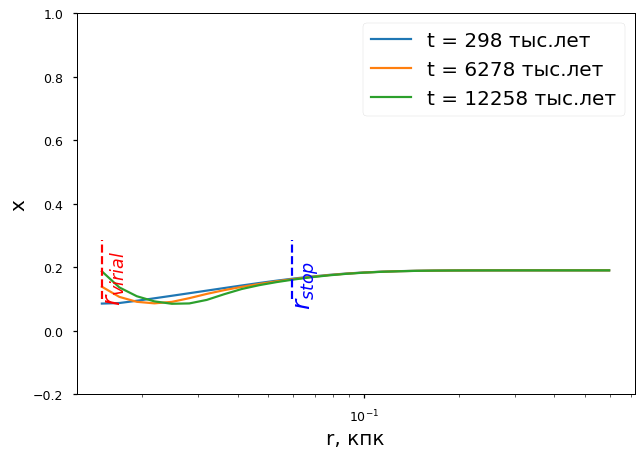

In [24]:
# Отрисовка степени ионизации
import matplotlib.pyplot as plt
Font = 16

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 1
draw_time_step = 20

fig, ax = plt.subplots()

for t in range(draw_time_zero, x_draw.shape[0], draw_time_step):
    ax.plot(r_phys[:]*1e-3, x_draw[t, :], label=f"t = {int(draw_time[t] * 3.169e-8 * 1e-3)} тыс.лет")
ax.legend(fontsize = Font)
ax.set_xlabel(r"r, кпк",fontsize = Font)
ax.set_ylabel(r"x",fontsize = Font)

ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylim(-0.2, 1)
# ax.set_xlim(0,9)

#Добавляем вертикальные линии в точках r_virial и r_s
plt.vlines(x=[r_virial*1e-3, r_s*1e-3], ymin=0.1, ymax=x_draw.max(), colors=['red', 'blue'], linestyles='dashed')

plt.text(x=r_virial*1e-3+0.0001, y=0.1, s=r"$r_{virial}$", color='red', rotation=90)
plt.text(x=r_s*1e-3+0.001, y=0.1, s=r"$r_{stop}$", color='blue', rotation=90)

plt.show()
# plt.savefig('Rho_1.eps')

In [ ]:
# Отрисовка скорости
import matplotlib.pyplot as plt

#Задаем начальное значение и шаг по времени для отрисовки графиков
draw_time_zero = 0
draw_time_step = 1

# создаем фигуру и оси
fig, ax = plt.subplots()

# перебираем значения draw_time от 0 до length_t-1 с шагом draw_time_step
for t in range(draw_time_zero, U_draw.shape[0], draw_time_step):
    # рисуем график значений Rho[t, :] и r[:] с подписью t
    ax.plot(r_phys, U_draw[t, :], label=f"t = {draw_time[t] * 3.169e-8}")

# добавляем легенду
ax.legend()
# ax.set_ylim(2500, 3500)
# ax.set_xlim(10,12)

# показываем фигуру
plt.show()